# préambule

Durant ce projet nous allons chercher à convertir une chaine de caractère en un QRCodes de type 1. Les caractèristiques des QRCodes de type 1 imposent que la chaine de caractère soit d'une longueur inférieur ou égale à 17 caractères. Vous pouvez donc entrer le texte que vous souhaitez dans la variable phrase tant que cela n'exède pas cette limite. Vous pourrez ensuite visualiser le résultat, après avoir éxécuté tout le code, en scannant le QRCode avec votre téléphone.

# WARNING

Pour générer le QRCode, ce code dois faire appel à des codes correcteurs d'erreurs de type reed_solomon. Ces codes étant très longs et complexes à programmer, nous avons choisi de passer par l'intermediaire de la librairie reedsolo. Il est possible que vous rencontriez quelques difficultés pour installer cette librairie, c'est pourquoi je vous conseille, avant toute modification de la chaine de caractère, d'aller tester le résultat sur le QRCode pré-généré qui se trouve à la fin de ce notebook. En effet dans le cas ou vous ne parviendriez pas à installer cette librairie, il ne vous sera pas possible de générer votre propre QRCode, et il serait donc dommage que vous ne puissiez pas tout de même tester le résultat de ce projet.

## entrer votre texte entre guillemets

In [296]:
phrase = "hello ECM"

# Import

In [297]:
from reedsolo import RSCodec, ReedSolomonError
import numpy as np
import matplotlib.pyplot as plt

# conversion de la phrase en binaire

##### conversion de chaque caractère en binaire, sur 8 bits (format UTF-8)

In [298]:
phrase_binaire=[]
for i in range(len(phrase)):
    phrase_binaire.append(format(ord(phrase[i]), '08b'))

In [299]:
phrase_binaire

['01101000',
 '01100101',
 '01101100',
 '01101100',
 '01101111',
 '00100000',
 '01000101',
 '01000011',
 '01001101']

##### ajout de la taille de la chaine de caractère et du type de correction d'erreur (ici nous avons choisi une correction d'erreur faible (<7%))

In [300]:
size = format(len(phrase_binaire), '08b')

In [301]:
information = []
information.append('0100' + size[0:4])
information.append(size[4:])
for i in range(len(phrase_binaire)):
    information[-1] = str(information[-1]) + phrase_binaire[i][0:4]
    information.append(phrase_binaire[i][4:])
information[-1] = str(information[-1]) + '0000'
information

['01000000',
 '10010110',
 '10000110',
 '01010110',
 '11000110',
 '11000110',
 '11110010',
 '00000100',
 '01010100',
 '00110100',
 '11010000']

##### completion de la chaine d'information avec un motif conventionnel afin d'atteindre la taille necessaire pour un QRCode de type 1

In [302]:
alternance = True
while len(information) < 19:
    if alternance:
        information.append('11101100')
        alternance = False
    else:
        information.append('00010001')
        alternance = True
information

['01000000',
 '10010110',
 '10000110',
 '01010110',
 '11000110',
 '11000110',
 '11110010',
 '00000100',
 '01010100',
 '00110100',
 '11010000',
 '11101100',
 '00010001',
 '11101100',
 '00010001',
 '11101100',
 '00010001',
 '11101100',
 '00010001']

##### traduction de la suite binaire en une suite d'entier pour preparer la génération des codes correcteurs d'erreurs

In [303]:
def toint(x):
    result = 0
    for i in range(len(x)):
        result += int(x[len(x)-1-i])*2**i
    return result

In [304]:
new_info = []
for x in information:
    new_info.append(toint(x))
    
new_info

[64,
 150,
 134,
 86,
 198,
 198,
 242,
 4,
 84,
 52,
 208,
 236,
 17,
 236,
 17,
 236,
 17,
 236,
 17]

##### génération des codes correcteurs d'erreurs et obtention de la chaine binaire finale

In [305]:
rsc = RSCodec(7)
final_information = rsc.encode(new_info)

In [306]:
bytes_as_bits = ''.join(format(byte, '08b') for byte in final_information)
bytes_as_bits

'0100000010010110100001100101011011000110110001101111001000000100010101000011010011010000111011000001000111101100000100011110110000010001111011000001000110100110111000100110011001101001011110010110011100010101'

On a donc ici la chaine binaire final, qui sera encodée dans la matrice du QRCode. Il nous faut maintenant générer cette matrice en respectant toute les contraintes liées au format pour pouvoir enfin avoir notre QRCode.

# création de la matrice

##### création d'une matrice vierge

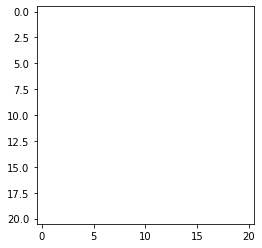

In [307]:
qrcode = np.asarray(21*[21*[[255,255,255]]])

# prévisualisation
plt.imshow(qrcode)

###### ajout des paternes de détection

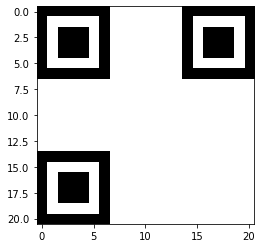

In [308]:
find_patern = np.asarray([[[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]],[[0,0,0],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[0,0,0]],[[0,0,0],[255,255,255],[0,0,0],[0,0,0],[0,0,0],[255,255,255],[0,0,0]],[[0,0,0],[255,255,255],[0,0,0],[0,0,0],[0,0,0],[255,255,255],[0,0,0]],[[0,0,0],[255,255,255],[0,0,0],[0,0,0],[0,0,0],[255,255,255],[0,0,0]],[[0,0,0],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[255,255,255],[0,0,0]],[[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]])

qrcode[:7,:7,:] = find_patern
qrcode[14:,:7,:] = find_patern
qrcode[:7,14:,:] = find_patern

# prévisualisation
plt.imshow(qrcode)

##### ajout des paternes d'alignement

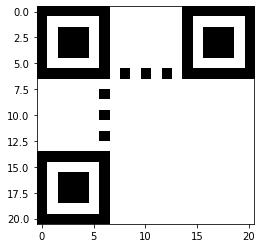

In [309]:
qrcode[6,7:14,:] = [[255,255,255],[0,0,0],[255,255,255],[0,0,0],[255,255,255],[0,0,0],[255,255,255]]
qrcode[7:14,6,:] = [[255,255,255],[0,0,0],[255,255,255],[0,0,0],[255,255,255],[0,0,0],[255,255,255]]

# prévisualisation
plt.imshow(qrcode)

##### ajout des informations sur le format des données

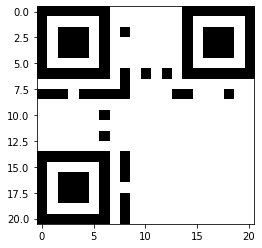

In [310]:
qrcode[14:,8,:] = [[0,0,0],[0,0,0],[0,0,0],[255,255,255],[0,0,0],[0,0,0],[0,0,0]]
qrcode[8,:6,:] = [[0,0,0],[0,0,0],[0,0,0],[255,255,255],[0,0,0],[0,0,0]]
qrcode[8,7:9,:] = [[0,0,0],[0,0,0]]
qrcode[7,8,:] = [0,0,0]
qrcode[2,8,:] = [0,0,0]

qrcode[8,13:15,:] = [[0,0,0],[0,0,0]]
qrcode[8,18,:] = [0,0,0]

# prévisualisation
plt.imshow(qrcode)

##### création du masque permetant l'ajout des informations dans le QRCode

In [311]:
masque = []
for x in range(0,21):
    masque.append([])
    for y in range(0,21):
        
        if (x+y)%2 == 0:
            masque[-1].append(True)
        else:
            masque[-1].append(False)
            
def masquage(i,j,bit):
    if masque[i][j] :
        if bit == 1:
            return [255,255,255]
        else:
            return [0,0,0]
    else:
        if bit == 1:
            return [0,0,0]
        else:
            return [255,255,255]

##### integration de la séquence binaire dans le QRCode

Cette partie n'est ni la plus passionnante ni la plus complexe, car elle ne consiste qu'à entrer les valeurs binaires une à une dans la matrice. Cependant cette fonction ne peut pas etre faite via une ou plusieurs boucles à cause du sens de lecture du QRCode qui est très particulier. Ainsi cette tache doit etre réalisé bit par bit.

In [312]:
# colone 1-2

qrcode[20,20,:] = masquage(20,20,int(bytes_as_bits[0]))
qrcode[20,19,:] = masquage(20,19,int(bytes_as_bits[1]))
qrcode[19,20,:] = masquage(19,20,int(bytes_as_bits[2]))
qrcode[19,19,:] = masquage(19,19,int(bytes_as_bits[3]))
qrcode[18,20,:] = masquage(18,20,int(bytes_as_bits[4]))
qrcode[18,19,:] = masquage(18,19,int(bytes_as_bits[5]))
qrcode[17,20,:] = masquage(17,20,int(bytes_as_bits[6]))
qrcode[17,19,:] = masquage(17,19,int(bytes_as_bits[7]))

qrcode[16,20,:] = masquage(16,20,int(bytes_as_bits[8]))
qrcode[16,19,:] = masquage(16,19,int(bytes_as_bits[9]))
qrcode[15,20,:] = masquage(15,20,int(bytes_as_bits[10]))
qrcode[15,19,:] = masquage(15,19,int(bytes_as_bits[11]))
qrcode[14,20,:] = masquage(14,20,int(bytes_as_bits[12]))
qrcode[14,19,:] = masquage(14,19,int(bytes_as_bits[13]))
qrcode[13,20,:] = masquage(13,20,int(bytes_as_bits[14]))
qrcode[13,19,:] = masquage(13,19,int(bytes_as_bits[15]))

qrcode[12,20,:] = masquage(12,20,int(bytes_as_bits[16]))
qrcode[12,19,:] = masquage(12,19,int(bytes_as_bits[17]))
qrcode[11,20,:] = masquage(11,20,int(bytes_as_bits[18]))
qrcode[11,19,:] = masquage(11,19,int(bytes_as_bits[19]))
qrcode[10,20,:] = masquage(10,20,int(bytes_as_bits[20]))
qrcode[10,19,:] = masquage(10,19,int(bytes_as_bits[21]))
qrcode[9,20,:] = masquage(9,20,int(bytes_as_bits[22]))
qrcode[9,19,:] = masquage(9,19,int(bytes_as_bits[23]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 3-4

qrcode[20,18,:] = masquage(20,18,int(bytes_as_bits[46]))
qrcode[20,17,:] = masquage(20,17,int(bytes_as_bits[47]))
qrcode[19,18,:] = masquage(19,18,int(bytes_as_bits[44]))
qrcode[19,17,:] = masquage(19,17,int(bytes_as_bits[45]))
qrcode[18,18,:] = masquage(18,18,int(bytes_as_bits[42]))
qrcode[18,17,:] = masquage(18,17,int(bytes_as_bits[43]))
qrcode[17,18,:] = masquage(17,18,int(bytes_as_bits[40]))
qrcode[17,17,:] = masquage(17,17,int(bytes_as_bits[41]))

qrcode[16,18,:] = masquage(16,18,int(bytes_as_bits[38]))
qrcode[16,17,:] = masquage(16,17,int(bytes_as_bits[39]))
qrcode[15,18,:] = masquage(15,18,int(bytes_as_bits[36]))
qrcode[15,17,:] = masquage(15,17,int(bytes_as_bits[37]))
qrcode[14,18,:] = masquage(14,18,int(bytes_as_bits[34]))
qrcode[14,17,:] = masquage(14,17,int(bytes_as_bits[35]))
qrcode[13,18,:] = masquage(13,18,int(bytes_as_bits[32]))
qrcode[13,17,:] = masquage(13,17,int(bytes_as_bits[33]))

qrcode[12,18,:] = masquage(12,18,int(bytes_as_bits[30]))
qrcode[12,17,:] = masquage(12,17,int(bytes_as_bits[31]))
qrcode[11,18,:] = masquage(11,18,int(bytes_as_bits[28]))
qrcode[11,17,:] = masquage(11,17,int(bytes_as_bits[29]))
qrcode[10,18,:] = masquage(10,18,int(bytes_as_bits[26]))
qrcode[10,17,:] = masquage(10,17,int(bytes_as_bits[27]))
qrcode[9,18,:] = masquage(9,18,int(bytes_as_bits[24]))
qrcode[9,17,:] = masquage(9,17,int(bytes_as_bits[25]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 5-6

qrcode[20,16,:] = masquage(20,16,int(bytes_as_bits[48]))
qrcode[20,15,:] = masquage(20,15,int(bytes_as_bits[49]))
qrcode[19,16,:] = masquage(19,16,int(bytes_as_bits[50]))
qrcode[19,15,:] = masquage(19,15,int(bytes_as_bits[51]))
qrcode[18,16,:] = masquage(18,16,int(bytes_as_bits[52]))
qrcode[18,15,:] = masquage(18,15,int(bytes_as_bits[53]))
qrcode[17,16,:] = masquage(17,16,int(bytes_as_bits[54]))
qrcode[17,15,:] = masquage(17,15,int(bytes_as_bits[55]))

qrcode[16,16,:] = masquage(16,16,int(bytes_as_bits[56]))
qrcode[16,15,:] = masquage(16,15,int(bytes_as_bits[57]))
qrcode[15,16,:] = masquage(15,16,int(bytes_as_bits[58]))
qrcode[15,15,:] = masquage(15,15,int(bytes_as_bits[59]))
qrcode[14,16,:] = masquage(14,16,int(bytes_as_bits[60]))
qrcode[14,15,:] = masquage(14,15,int(bytes_as_bits[61]))
qrcode[13,16,:] = masquage(13,16,int(bytes_as_bits[62]))
qrcode[13,15,:] = masquage(13,15,int(bytes_as_bits[63]))

qrcode[12,16,:] = masquage(12,16,int(bytes_as_bits[64]))
qrcode[12,15,:] = masquage(12,15,int(bytes_as_bits[65]))
qrcode[11,16,:] = masquage(11,16,int(bytes_as_bits[66]))
qrcode[11,15,:] = masquage(11,15,int(bytes_as_bits[67]))
qrcode[10,16,:] = masquage(10,16,int(bytes_as_bits[68]))
qrcode[10,15,:] = masquage(10,15,int(bytes_as_bits[69]))
qrcode[9,16,:] = masquage(9,16,int(bytes_as_bits[70]))
qrcode[9,15,:] = masquage(9,15,int(bytes_as_bits[71]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 7-8

qrcode[20,14,:] = masquage(20,14,int(bytes_as_bits[94]))
qrcode[20,13,:] = masquage(20,13,int(bytes_as_bits[95]))
qrcode[19,14,:] = masquage(19,14,int(bytes_as_bits[92]))
qrcode[19,13,:] = masquage(19,13,int(bytes_as_bits[93]))
qrcode[18,14,:] = masquage(18,14,int(bytes_as_bits[90]))
qrcode[18,13,:] = masquage(18,13,int(bytes_as_bits[91]))
qrcode[17,14,:] = masquage(17,14,int(bytes_as_bits[88]))
qrcode[17,13,:] = masquage(17,13,int(bytes_as_bits[89]))

qrcode[16,14,:] = masquage(16,14,int(bytes_as_bits[86]))
qrcode[16,13,:] = masquage(16,13,int(bytes_as_bits[87]))
qrcode[15,14,:] = masquage(15,14,int(bytes_as_bits[84]))
qrcode[15,13,:] = masquage(15,13,int(bytes_as_bits[85]))
qrcode[14,14,:] = masquage(14,14,int(bytes_as_bits[82]))
qrcode[14,13,:] = masquage(14,13,int(bytes_as_bits[83]))
qrcode[13,14,:] = masquage(13,14,int(bytes_as_bits[80]))
qrcode[13,13,:] = masquage(13,13,int(bytes_as_bits[81]))

qrcode[12,14,:] = masquage(12,14,int(bytes_as_bits[78]))
qrcode[12,13,:] = masquage(12,13,int(bytes_as_bits[79]))
qrcode[11,14,:] = masquage(11,14,int(bytes_as_bits[76]))
qrcode[11,13,:] = masquage(11,13,int(bytes_as_bits[77]))
qrcode[10,14,:] = masquage(10,14,int(bytes_as_bits[74]))
qrcode[10,13,:] = masquage(10,13,int(bytes_as_bits[75]))
qrcode[9,14,:] = masquage(9,14,int(bytes_as_bits[72]))
qrcode[9,13,:] = masquage(9,13,int(bytes_as_bits[73]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 9-10

qrcode[20,12,:] = masquage(20,12,int(bytes_as_bits[96]))
qrcode[20,11,:] = masquage(20,11,int(bytes_as_bits[97]))
qrcode[19,12,:] = masquage(19,12,int(bytes_as_bits[98]))
qrcode[19,11,:] = masquage(19,11,int(bytes_as_bits[99]))
qrcode[18,12,:] = masquage(18,12,int(bytes_as_bits[100]))
qrcode[18,11,:] = masquage(18,11,int(bytes_as_bits[101]))
qrcode[17,12,:] = masquage(17,12,int(bytes_as_bits[102]))
qrcode[17,11,:] = masquage(17,11,int(bytes_as_bits[103]))

qrcode[16,12,:] = masquage(16,12,int(bytes_as_bits[104]))
qrcode[16,11,:] = masquage(16,11,int(bytes_as_bits[105]))
qrcode[15,12,:] = masquage(15,12,int(bytes_as_bits[106]))
qrcode[15,11,:] = masquage(15,11,int(bytes_as_bits[107]))
qrcode[14,12,:] = masquage(14,12,int(bytes_as_bits[108]))
qrcode[14,11,:] = masquage(14,11,int(bytes_as_bits[109]))
qrcode[13,12,:] = masquage(13,12,int(bytes_as_bits[110]))
qrcode[13,11,:] = masquage(13,11,int(bytes_as_bits[111]))

qrcode[12,12,:] = masquage(12,12,int(bytes_as_bits[112]))
qrcode[12,11,:] = masquage(12,11,int(bytes_as_bits[113]))
qrcode[11,12,:] = masquage(11,12,int(bytes_as_bits[114]))
qrcode[11,11,:] = masquage(11,11,int(bytes_as_bits[115]))
qrcode[10,12,:] = masquage(10,12,int(bytes_as_bits[116]))
qrcode[10,11,:] = masquage(10,11,int(bytes_as_bits[117]))
qrcode[9,12,:] = masquage(9,12,int(bytes_as_bits[118]))
qrcode[9,11,:] = masquage(9,11,int(bytes_as_bits[119]))

qrcode[8,12,:] = masquage(8,12,int(bytes_as_bits[120]))
qrcode[8,11,:] = masquage(8,11,int(bytes_as_bits[121]))
qrcode[7,12,:] = masquage(7,12,int(bytes_as_bits[122]))
qrcode[7,11,:] = masquage(7,11,int(bytes_as_bits[123]))
qrcode[5,12,:] = masquage(5,12,int(bytes_as_bits[124]))
qrcode[5,11,:] = masquage(5,11,int(bytes_as_bits[125]))
qrcode[4,12,:] = masquage(4,12,int(bytes_as_bits[126]))
qrcode[4,11,:] = masquage(4,11,int(bytes_as_bits[127]))

qrcode[3,12,:] = masquage(3,12,int(bytes_as_bits[128]))
qrcode[3,11,:] = masquage(3,11,int(bytes_as_bits[129]))
qrcode[2,12,:] = masquage(2,12,int(bytes_as_bits[130]))
qrcode[2,11,:] = masquage(2,11,int(bytes_as_bits[131]))
qrcode[1,12,:] = masquage(1,12,int(bytes_as_bits[132]))
qrcode[1,11,:] = masquage(1,11,int(bytes_as_bits[133]))
qrcode[0,12,:] = masquage(0,12,int(bytes_as_bits[134]))
qrcode[0,11,:] = masquage(0,11,int(bytes_as_bits[135]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 11-12

qrcode[20,10,:] = masquage(20,10,int(bytes_as_bits[174]))
qrcode[20,9,:] = masquage(20,9,int(bytes_as_bits[175]))
qrcode[19,10,:] = masquage(19,10,int(bytes_as_bits[172]))
qrcode[19,9,:] = masquage(19,9,int(bytes_as_bits[173]))
qrcode[18,10,:] = masquage(18,10,int(bytes_as_bits[170]))
qrcode[18,9,:] = masquage(18,9,int(bytes_as_bits[171]))
qrcode[17,10,:] = masquage(17,10,int(bytes_as_bits[168]))
qrcode[17,9,:] = masquage(17,9,int(bytes_as_bits[169]))

qrcode[16,10,:] = masquage(16,10,int(bytes_as_bits[166]))
qrcode[16,9,:] = masquage(16,9,int(bytes_as_bits[167]))
qrcode[15,10,:] = masquage(15,10,int(bytes_as_bits[164]))
qrcode[15,9,:] = masquage(15,9,int(bytes_as_bits[165]))
qrcode[14,10,:] = masquage(14,10,int(bytes_as_bits[162]))
qrcode[14,9,:] = masquage(14,9,int(bytes_as_bits[163]))
qrcode[13,10,:] = masquage(13,10,int(bytes_as_bits[160]))
qrcode[13,9,:] = masquage(13,9,int(bytes_as_bits[161]))

qrcode[12,10,:] = masquage(12,10,int(bytes_as_bits[158]))
qrcode[12,9,:] = masquage(12,9,int(bytes_as_bits[159]))
qrcode[11,10,:] = masquage(11,10,int(bytes_as_bits[156]))
qrcode[11,9,:] = masquage(11,9,int(bytes_as_bits[157]))
qrcode[10,10,:] = masquage(10,10,int(bytes_as_bits[154]))
qrcode[10,9,:] = masquage(10,9,int(bytes_as_bits[155]))
qrcode[9,10,:] = masquage(9,10,int(bytes_as_bits[152]))
qrcode[9,9,:] = masquage(9,9,int(bytes_as_bits[153]))

qrcode[8,10,:] = masquage(8,10,int(bytes_as_bits[150]))
qrcode[8,9,:] = masquage(8,9,int(bytes_as_bits[151]))
qrcode[7,10,:] = masquage(7,10,int(bytes_as_bits[148]))
qrcode[7,9,:] = masquage(7,9,int(bytes_as_bits[149]))
qrcode[5,10,:] = masquage(5,10,int(bytes_as_bits[146]))
qrcode[5,9,:] = masquage(5,9,int(bytes_as_bits[147]))
qrcode[4,10,:] = masquage(4,10,int(bytes_as_bits[144]))
qrcode[4,9,:] = masquage(4,9,int(bytes_as_bits[145]))

qrcode[3,10,:] = masquage(3,10,int(bytes_as_bits[142]))
qrcode[3,9,:] = masquage(3,9,int(bytes_as_bits[143]))
qrcode[2,10,:] = masquage(2,10,int(bytes_as_bits[140]))
qrcode[2,9,:] = masquage(2,9,int(bytes_as_bits[141]))
qrcode[1,10,:] = masquage(1,10,int(bytes_as_bits[138]))
qrcode[1,9,:] = masquage(1,9,int(bytes_as_bits[139]))
qrcode[0,10,:] = masquage(0,10,int(bytes_as_bits[136]))
qrcode[0,9,:] = masquage(0,9,int(bytes_as_bits[137]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 13-14

qrcode[12,8,:] = masquage(12,8,int(bytes_as_bits[176]))
qrcode[12,7,:] = masquage(12,7,int(bytes_as_bits[177]))
qrcode[11,8,:] = masquage(11,8,int(bytes_as_bits[178]))
qrcode[11,7,:] = masquage(11,7,int(bytes_as_bits[179]))
qrcode[10,8,:] = masquage(10,8,int(bytes_as_bits[180]))
qrcode[10,7,:] = masquage(10,7,int(bytes_as_bits[181]))
qrcode[9,8,:] = masquage(9,8,int(bytes_as_bits[182]))
qrcode[9,7,:] = masquage(9,7,int(bytes_as_bits[183]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 16-17

qrcode[12,5,:] = masquage(12,5,int(bytes_as_bits[190]))
qrcode[12,4,:] = masquage(12,4,int(bytes_as_bits[191]))
qrcode[11,5,:] = masquage(11,5,int(bytes_as_bits[188]))
qrcode[11,4,:] = masquage(11,4,int(bytes_as_bits[189]))
qrcode[10,5,:] = masquage(10,5,int(bytes_as_bits[186]))
qrcode[10,4,:] = masquage(10,4,int(bytes_as_bits[187]))
qrcode[9,5,:] = masquage(9,5,int(bytes_as_bits[184]))
qrcode[9,4,:] = masquage(9,4,int(bytes_as_bits[185]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 18-19

qrcode[12,3,:] = masquage(12,3,int(bytes_as_bits[192]))
qrcode[12,2,:] = masquage(12,2,int(bytes_as_bits[193]))
qrcode[11,3,:] = masquage(11,3,int(bytes_as_bits[194]))
qrcode[11,2,:] = masquage(11,2,int(bytes_as_bits[195]))
qrcode[10,3,:] = masquage(10,3,int(bytes_as_bits[196]))
qrcode[10,2,:] = masquage(10,2,int(bytes_as_bits[197]))
qrcode[9,3,:] = masquage(9,3,int(bytes_as_bits[198]))
qrcode[9,2,:] = masquage(9,2,int(bytes_as_bits[199]))

# ------------------------------------------------------------------------------------------------------------------------
# colone 20-21

qrcode[12,1,:] = masquage(12,1,int(bytes_as_bits[206]))
qrcode[12,0,:] = masquage(12,0,int(bytes_as_bits[207]))
qrcode[11,1,:] = masquage(11,1,int(bytes_as_bits[204]))
qrcode[11,0,:] = masquage(11,0,int(bytes_as_bits[205]))
qrcode[10,1,:] = masquage(10,1,int(bytes_as_bits[202]))
qrcode[10,0,:] = masquage(10,0,int(bytes_as_bits[203]))
qrcode[9,1,:] = masquage(9,1,int(bytes_as_bits[200]))
qrcode[9,0,:] = masquage(9,0,int(bytes_as_bits[201]))

# visualisation du résultat

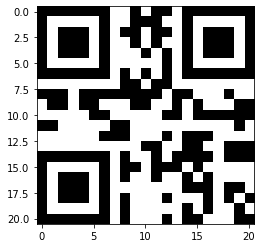

In [313]:
plt.imshow(qrcode)